### Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

**Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.**

### Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

Variable|Description   
:---- |:----
Item_Identifier|Unique product ID
Item_Weight|Weight of product
Item_Fat_Content|Whether the product is low fat or not
Item_Visibility|The % of total display area of all products in a store allocated to the particular product
Item_Type|The category to which the product belongs
Item_MRP|Maximum Retail Price (list price) of the product
Outlet_Identifier|Unique store ID
Outlet_Establishment_Year|The year in which store was established
Outlet_Size|The size of the store in terms of ground area covered
Outlet_Location_Type|The type of city in which the store is located
Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales|Sales of the product in the particular store. This is the outcome variable to be predicted.

### Evaluation Metric:

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the **Root Mean Square Error** value to judge your response.



Where,
N: total number of observations
Predicted: the response entered by user
Actual: actual values of sales

Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.
 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
sns.set()

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#### Chi Square Test
>**Chi-Square Test**: This test is used to derive the statistical significance of relationship between the variables. Also, it tests whether the evidence in the sample is strong enough to generalize that the relationship for a larger population as well. Chi-square is based on the difference between the expected and observed frequencies in one or more categories in the two-way table. It returns probability for the computed chi-square distribution with the degree of freedom.
- Probability of 0: It indicates that both categorical variable are dependent
- Probability of 1: It shows that both variables are independent.

In [5]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def test_chi2(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)


In [6]:
target ='Item_Outlet_Sales'

In [7]:
def get_predictors(df,target):
    return [col for col in df.columns if col!=target]

In [8]:
def plot_histograms(df):
    f = pd.melt(df) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

In [9]:
def extended_describe(dataframe):
    extended_describe_df= dataframe.describe(include='all').T 
    extended_describe_df['null_count']= dataframe.isnull().sum()
    extended_describe_df['unique_count'] = dataframe.apply(lambda x: len(x.unique()))
    return extended_describe_df 

In [10]:
train_file  = 'train.csv'
test_file  = 'test.csv'

In [11]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
predictors = get_predictors(train_df,target)
data = pd.concat([train_df, test_df],ignore_index=True)

In [12]:
from mltools.eda import eda

In [13]:
null_df = eda.null_analysis(train_df)

In [14]:
null_df

,counts,percentage
Outlet_Size,2410,28.2764
Item_Weight,1463,17.1653


#### Variable Identification , descriptive statistics

In [15]:
extended_describe(train_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,8523,1559,FDG33,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1559
Item_Weight,7060.0000,NaN,NaN,NaN,12.8576,4.6435,4.5550,8.7737,12.6000,16.8500,21.3500,1463,416
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,8523.0000,NaN,NaN,NaN,0.0661,0.0516,0.0000,0.0270,0.0539,0.0946,0.3284,0,7880
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,8523.0000,NaN,NaN,NaN,140.9928,62.2751,31.2900,93.8265,143.0128,185.6437,266.8884,0,5938
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,8523.0000,NaN,NaN,NaN,1997.8319,8.3718,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2410,4
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [16]:
extended_describe(test_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,5681,1543,DRF48,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1543
Item_Weight,4705.0000,NaN,NaN,NaN,12.6956,4.6648,4.5550,8.6450,12.5000,16.7000,21.3500,976,411
Item_Fat_Content,5681,5,Low Fat,3396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,5681.0000,NaN,NaN,NaN,0.0657,0.0513,0.0000,0.0270,0.0542,0.0935,0.3236,0,5277
Item_Type,5681,16,Snack Foods,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,5681.0000,NaN,NaN,NaN,141.0233,61.8091,31.9900,94.4120,141.4154,186.0266,266.5884,0,4402
Outlet_Identifier,5681,10,OUT027,624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,5681.0000,NaN,NaN,NaN,1997.8289,8.3723,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,4075,3,Medium,1862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606,4
Outlet_Location_Type,5681,3,Tier 3,2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [17]:
replace_fc = {'LF': 'Low Fat', 'low fat': 'Low Fat' ,'low fat':'Low Fat',
              'reg':'Regular','Low Fat':'Low Fat','Regular' :'Regular'}

In [18]:
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(replace_fc)
test_df['Item_Fat_Content'] =  test_df['Item_Fat_Content'].map(replace_fc)

#### Pandas Profiling report

In [19]:
profile = pandas_profiling.ProfileReport(train_df)
profile.to_file(output_file="BigMart_data_profiling.html")

In [20]:
train_num_df = train_df.select_dtypes(include=['float64','int64'])
train_num_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.3000,0.0160,249.8092,1999,3735.1380
1,5.9200,0.0193,48.2692,2009,443.4228
2,17.5000,0.0168,141.6180,1999,2097.2700
3,19.2000,0.0000,182.0950,1998,732.3800
4,8.9300,0.0000,53.8614,1987,994.7052


In [21]:
# Also none of quantitative variables has normal distribution so these should be transformed as well.
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_num_df)
normal = normal.apply(test_normality)
print(not normal.any())

False


#### Univariate Analysis - Continuous Variables

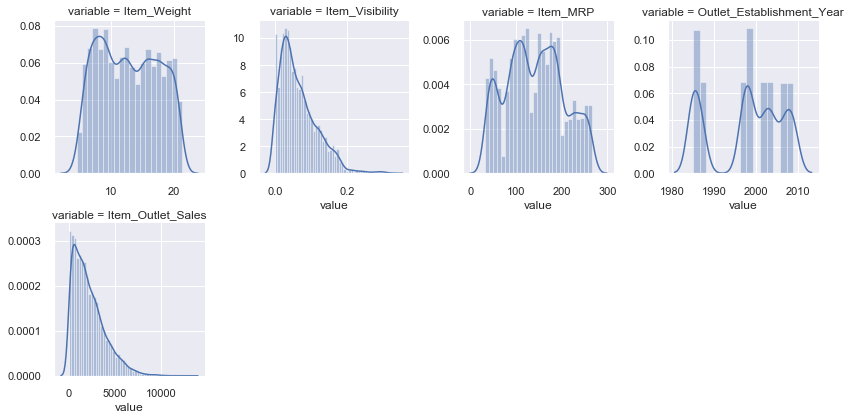

In [22]:
plot_histograms(train_num_df)

#### Inferences on Numeric columns

>- **Item_Weight**: Doesn't have uniform distribution as it depends type of item 
- **Item_Visibility**: Right skewed distribution,check if we need to apply power transformation to reduce the skewness
- **Item_MRP**: Doesn't have uniform distribution as it depends type of item
- **Item_Outlet_Sales**: Check if we need apply any log transformation 


#### Univariate Analysis - Categorical Variables

In [23]:
exclude_cols  = list(train_num_df.columns)
exclude_cols.append('Item_Identifier')
qualitative = [col for col in train_df.columns if col not in  exclude_cols] 

In [24]:
for column in qualitative:
    train_df[column] = train_df[column].astype('category')
    if train_df[column].isnull().any():
        train_df[column] = train_df[column].cat.add_categories(['MISSING'])
        train_df[column] = train_df[column].fillna('MISSING')

In [25]:
def plot_countplot(df):
    f = pd.melt(df) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g.set_xticklabels(rotation=90)
    g = g.map(sns.countplot, 'value')
    
    return g

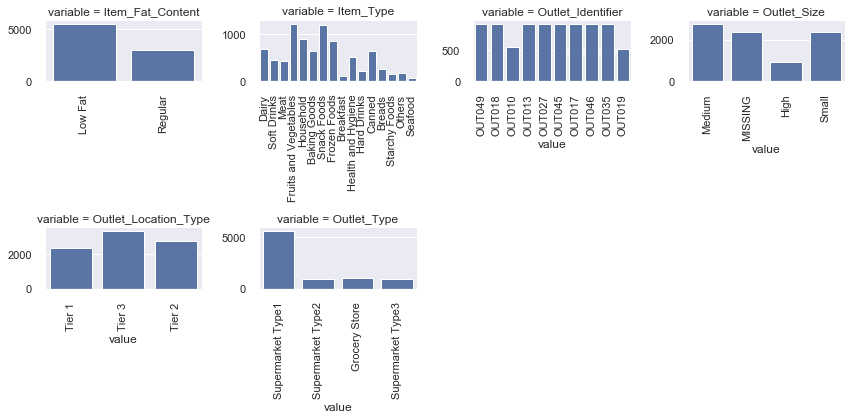

In [26]:
plot_countplot(train_df[qualitative])

####  Bi-variate Analysis  Categorical vs Target

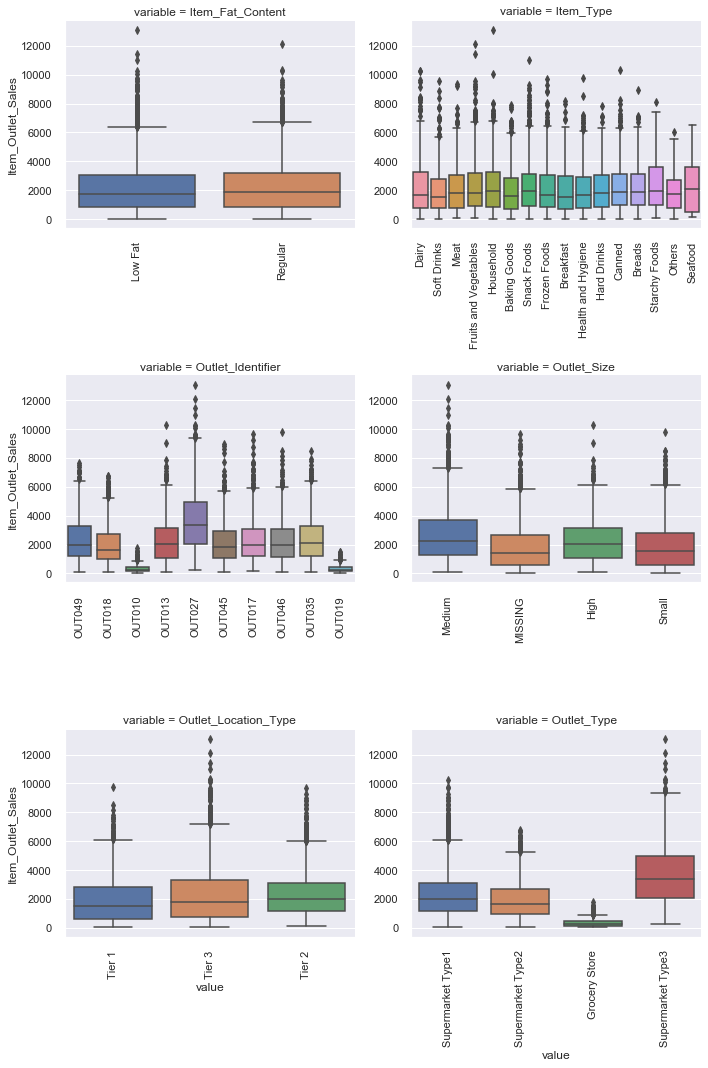

In [27]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train_df, id_vars=['Item_Outlet_Sales'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "Item_Outlet_Sales")

#### Inferences  from categorical variables
> - **Outlet_Type**: Supermarket Type3 has high sales  and Grocery Store  has lowest sales
- **Outlet_Location_Type**: Tier3 has marginally good Item Outlet_Sales


In [28]:
items_group = train_df.groupby(['Outlet_Identifier'])[target].agg(
    sales_avg=pd.NamedAgg(column='Item_Outlet_Sales', aggfunc='sum')).reset_index()

In [29]:
items_type_group = train_df.groupby(['Outlet_Type'])[target].agg(
    sales_avg=pd.NamedAgg(column='Outlet_Type_Sales', aggfunc='mean')).reset_index()

In [30]:
items_type_group

,Outlet_Type,sales_avg
0,Grocery Store,339.8285
1,Supermarket Type1,2316.1811
2,Supermarket Type2,1995.4987
3,Supermarket Type3,3694.0386


In [31]:
train_num_df = train_df.select_dtypes(include=['float64','int64'])
train_num_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.3000,0.0160,249.8092,1999,3735.1380
1,5.9200,0.0193,48.2692,2009,443.4228
2,17.5000,0.0168,141.6180,1999,2097.2700
3,19.2000,0.0000,182.0950,1998,732.3800
4,8.9300,0.0000,53.8614,1987,994.7052


In [32]:
train_df.groupby(['Item_Fat_Content'])['Item_Outlet_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Fat_Content,,,,,,,,
Low Fat,5517.0000,2157.7115,1697.9738,33.2900,826.2578,1765.0358,3050.6956,13086.9648
Regular,3006.0000,2224.5612,1721.4809,33.9558,857.5504,1844.5989,3198.6697,12117.5600


In [33]:
item_type  = train_df.groupby(['Outlet_Type','Item_Type'])['Item_Outlet_Sales'].describe().reset_index()
item_type = item_type.sort_values(['mean'], ascending=False)
item_type

,Outlet_Type,Item_Type,count,mean,std,min,25%,50%,75%,max
50,Supermarket Type3,Breakfast,11.0000,4584.7593,2552.0752,1518.0240,2670.8567,3866.9664,7137.0431,8209.3140
54,Supermarket Type3,Fruits and Vegetables,140.0000,4114.4871,2249.1649,417.4566,2284.8592,3996.7974,5308.5899,12117.5600
52,Supermarket Type3,Dairy,67.0000,3915.1822,2426.2771,905.4880,1943.8031,3435.5280,5462.2232,10236.6750
58,Supermarket Type3,Meat,56.0000,3862.2939,2179.4904,641.8312,2091.1113,3300.0377,5475.0399,9390.4432
57,Supermarket Type3,Household,99.0000,3821.2078,2261.4812,293.6178,2120.5730,3419.5488,5063.7419,13086.9648
...,...,...,...,...,...,...,...,...,...,...
15,Grocery Store,Starchy Foods,13.0000,300.1222,228.8079,58.5904,164.4526,185.0924,370.1848,852.2240
0,Grocery Store,Baking Goods,85.0000,292.0825,198.6280,37.2848,143.8128,223.7088,392.8220,792.3020
11,Grocery Store,Others,27.0000,288.0941,220.1813,39.9480,144.8115,214.3876,374.8454,815.6050
7,Grocery Store,Hard Drinks,24.0000,243.1557,194.5147,37.9506,100.2029,145.8102,394.4865,756.3488


In [34]:
location_size = train_df.groupby(['Outlet_Size','Outlet_Location_Type'])['Item_Outlet_Sales'].describe().reset_index()
location_size = location_size.sort_values(['mean'], ascending=False)
location_size

,Outlet_Size,Outlet_Location_Type,count,mean,std,min,25%,50%,75%,max
2,Medium,Tier 3,1863.0000,2847.9597,1983.7190,69.2432,1318.2840,2350.9398,3943.2005,13086.9648
4,Small,Tier 2,930.0000,2438.8419,1538.5125,113.8518,1238.8873,2109.2544,3310.3576,8479.6288
1,Medium,Tier 1,930.0000,2348.3546,1513.2895,111.8544,1182.7937,1966.1074,3281.7282,7646.0472
0,High,Tier 3,932.0000,2298.9953,1533.5317,73.2380,1072.6038,2050.6640,3166.3783,10256.6490
5,MISSING,Tier 2,1855.0000,2266.4101,1508.5829,99.8700,1133.8574,1946.7992,3020.0688,9664.7528
3,Small,Tier 1,1458.0000,1576.1929,1517.5231,33.9558,369.6855,1040.6454,2396.8800,9779.9362
6,MISSING,Tier 3,555.0000,339.3517,271.0149,33.2900,154.1327,250.3408,455.4072,1775.6886


In [35]:
# 3 way cross table
pd.crosstab([train_df['Outlet_Type'], train_df['Outlet_Size']],train_df['Item_Type'], margins=True)

Item_Type                      Baking Goods  Breads  Breakfast  Canned  Dairy  \
Outlet_Type       Outlet_Size                                                   
Grocery Store     Small                  43      16         10      38     49   
                  MISSING                42      17          9      35     43   
Supermarket Type1 High                   73      25         13      65     80   
                  Medium                 66      25         13      67     78   
                  Small                 144      55         20     151    149   
                  MISSING               143      55         22     143    143   
Supermarket Type2 Medium                 68      27         12      78     73   
Supermarket Type3 Medium                 69      31         11      72     67   
All                                     648     251        110     649    682   

Item_Type                      Frozen Foods  Fruits and Vegetables  \
Outlet_Type       Outlet_Size                                        
Grocery Store     Small                  49                     73   
                  MISSING                54                     79   
Supermarket Type1 High                   92                    142   
                  Medium                 93                    138   
                  Small                 200                    255   
                  MISSING               187                    270   
Supermarket Type2 Medium                 92                    135   
Supermarket Type3 Medium                 89                    140   
All                                     856                   1232   

Item_Type                      Hard Drinks  Health and Hygiene  Household  \
Outlet_Type       Outlet_Size                                               
Grocery Store     Small                  8                  30         52   
                  MISSING               16                  37         67   
Supermarket Type1 High                  23                  61        103   
                  Medium                30                  52         95   
                  Small                 42                 106        205   
                  MISSING               50                 116        194   
Supermarket Type2 Medium                22                  58         95   
Supermarket Type3 Medium                23                  60         99   
All                                    214                 520        910   

Item_Type                      Meat  Others  Seafood  Snack Foods  \
Outlet_Type       Outlet_Size                                       
Grocery Store     Small          32      17        6           75   
                  MISSING        34      10        4           71   
Supermarket Type1 High           41      16        5          125   
                  Medium         47      17        7          139   
                  Small          87      38       14          260   
                  MISSING        82      36       14          261   
Supermarket Type2 Medium         46      20        7          132   
Supermarket Type3 Medium         56      15        7          137   
All                             425     169       64         1200   

Item_Type                      Soft Drinks  Starchy Foods   All  
Outlet_Type       Outlet_Size                                    
Grocery Store     Small                 26              4   528  
                  MISSING               28              9   555  
Supermarket Type1 High                  49             19   932  
                  Medium                46             17   930  
                  Small                100             34  1860  
                  MISSING              105             34  1855  
Supermarket Type2 Medium                46             17   928  
Supermarket Type3 Medium                45             14   935  
All                                    445            148  8523

####  ChiSquare Test

In [36]:
ct = ChiSquare(train_df)
#Feature Selection
for var in qualitative:
    ct.test_chi2(colX=var,colY=target )  

Item_Fat_Content is IMPORTANT for Prediction
Item_Type is IMPORTANT for Prediction
Outlet_Identifier is IMPORTANT for Prediction
Outlet_Size is NOT an important predictor. (Discard Outlet_Size from model)
Outlet_Location_Type is IMPORTANT for Prediction
Outlet_Type is IMPORTANT for Prediction


#### Anova
>**ANOVA**:- It assesses whether the average of more than two groups is statistically different.

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

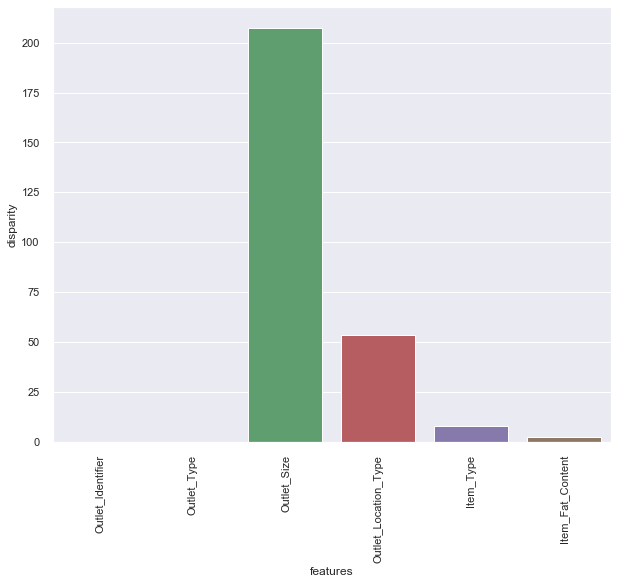

In [37]:
from scipy import stats
def anova(frame,categorical_features,target):
    anv = pd.DataFrame()
    anv['features'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls][target].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

 
k = anova(train_df,qualitative,target) 
k['disparity'] = np.log(1./k['pval'].values) 

plt.figure(figsize=(10,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

In [40]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,MISSING,Tier 3,Grocery Store,732.3800
4,NCD19,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [38]:
### Which Item has highest sales ?

In [55]:
Items_with_highest_sales =train_df.groupby(['Item_Identifier'])['Item_Outlet_Sales'].agg(sales_sum=pd.NamedAgg(column='Item_Outlet_Sales', aggfunc='sum')).reset_index() 

In [58]:
Items_with_highest_sales['SalesRank_byItem'] = Items_with_highest_sales['sales_sum'].rank(ascending=0,method='dense')

In [60]:
Items_with_highest_sales.sort_values(by=['SalesRank_byItem'])

,Item_Identifier,sales_sum,SalesRank_byItem
1210,FDY55,42661.8008,1.0000
156,FDA15,41584.5364,2.0000
1230,FDZ20,40185.0248,3.0000
359,FDF05,36555.7490,4.0000
148,FDA04,35741.4756,5.0000
...,...,...,...
777,FDQ04,784.3124,1488.0000
379,FDF38,771.6622,1489.0000
1200,FDY43,673.7896,1490.0000
1474,NCR42,332.9000,1491.0000


In [39]:
### Which Item has highest sales by store wise?

In [65]:
Items_with_highest_sales_by_store =train_df.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Outlet_Sales'].agg(sales_sum=pd.NamedAgg(column='Item_Outlet_Sales', aggfunc='sum')).reset_index() 

In [66]:
Items_with_highest_sales_by_store['SalesRank_byItem'] = Items_with_highest_sales_by_store['sales_sum'].rank(ascending=0,method='dense')

In [67]:
Items_with_highest_sales_by_store

,Item_Identifier,Outlet_Identifier,sales_sum,SalesRank_byItem
0,DRA12,OUT010,283.6308,3216.0000
1,DRA12,OUT013,2552.6772,1575.0000
2,DRA12,OUT017,2552.6772,1575.0000
3,DRA12,OUT018,850.8924,2731.0000
4,DRA12,OUT019,nan,nan
...,...,...,...,...
15585,NCZ54,OUT027,5523.4768,350.0000
15586,NCZ54,OUT035,nan,nan
15587,NCZ54,OUT045,2274.3728,1744.0000
15588,NCZ54,OUT046,4711.2008,581.0000


In [68]:
Items_with_highest_sales_by_store.to_csv('highest_sales.csv')